In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Draw import SimilarityMaps
from serenityff.charge.gnn.attention_extraction.extractor import Extractor

sdf_file = "../data/example.sdf"
model_path = "../data/example_model.pt"
extraction_path = "extraction.csv"

# Attention Extraction
This notebook demonstrate the tools used to extract the attention of nodes in a graph neural network trained to predict partial charges in small molecules.
Most of the extraction functionality is conviniently encapsulated in a Extractor class with many static functions. 
The function `run_extraction_local()` will run the pytorch GNNExplainer for every atom of all molecules in the provided sdf file with a GNN model provided. It will write the attention values and other important information, like indices, and chemical information to a csv file. For this demonstration notebook the number of epochs is set to 50, but for a production run this number should be increased for better averaging and a higher confidence of the attention values. Since these calculations can take a long time for large number of molecules and epochs, tools for parallelization on a cluster are also provided in the `Extractor` class.

In [2]:
Extractor.run_extraction_local(sdf_file=sdf_file, ml_model=model_path, epochs=50, output=extraction_path)

100%|██████████| 20/20 [00:00<00:00, 1289.11it/s]


After the attention extraction was run and saved to a file we can read the file and have a look at the data. The dataset contains chemical information, the attention data and charges for each atom. 
| Num | name | description |
| --------------- | --------------- | --------------- |
|  1. | index            |  the index in the pandas dataframe |
|  2. | atomtype         |  the element of the atom |
|  3. | smiles           |  the SMILES of the corresponding molecule, only stored for the first atom (0) of each molecule |
|  4. | idx_in_mol       |  index of the atom in the molecule |
|  5. | mol_index        |  the index of the molecule in the sdf file |
|  6. | node_attentions  |  the attention of all nodes (atoms) for this atom |
|  7. | edge_attentions  |  the attention of all edges (bonds) for this atom |
|  8. | prediction       |  the partial charge prediction of the GNN (in unit e), calculated from GNNExplainer |
|  9. | truth            |  the partial charge calculated as reference (in unit e) as saved in the sdf file as MBIScharge |

In [10]:
df = pd.read_csv(extraction_path)

In [11]:
df.head(2)

,atomtype,smiles,idx_in_mol,mol_index,node_attentions,edge_attentions,prediction,truth
0,C,[H]c1nnc2c(n1)c(=O)n(C([H])([H])[H])c(=O)n2[H],0,0,"[0.38190189003944397, 0.3966797888278961, 0.35...","[0.4070725739002228, 0.3622335195541382, 0.807...",-0.191903,-0.2029
1,N,NaN,1,0,"[0.39978164434432983, 0.6048610806465149, 0.39...","[0.6159964799880981, 0.6041354537010193, 0.642...",-0.372856,-0.3875


## Attention visualization
The data calculated above can be used to build a rule-based decision tree, as described in a different notebook. However, we can also directly analyze the attention values and observe some behavior on these example molecules. Therefore, we select a certain atom `atom_idx_to_draw = 2` in a certain molecule `mol_idx_to_draw = 0` which we want to study. And we can print the attention data for this atom, as well as the molecule it belongs to, by either generating the molecule from the SMILES, or by retrieving it from the sdf file.

In [29]:
atom_idx_to_draw = 2
mol_idx_to_draw = 0
attention_data_for_atom = eval(df[(df["idx_in_mol"] == atom_idx_to_draw) & (df["mol_index"] == mol_idx_to_draw)].iloc[0]["node_attentions"])
mol = Chem.SDMolSupplier(sdf_file, removeHs=False)[mol_idx_to_draw]
print(attention_data_for_atom)

[0.37503644824028015, 0.614233672618866, 0.476739764213562, 0.6030320525169373, 0.6186750531196594, 0.3704153299331665, 0.4330103099346161, 0.3792210519313812, 0.3898002803325653, 0.37630173563957214, 0.42261701822280884, 0.37245070934295654, 0.38545697927474976, 0.385390967130661, 0.4270486831665039, 0.41192302107810974, 0.40117985010147095, 0.3688623309135437]


Since the attention is normalized over the whole graph from GNNExplainer and not over a single molecule we can normalize it for a more consistent visualization.

In [30]:
def normalize_attention(attention_data):
    return np.array(attention_data) / np.sum(attention_data)

In [31]:
attention_data_for_atom_normalized = normalize_attention(attention_data_for_atom)

For nice plots (following) we also need to calculate nice 2D coordinates, since the read in 3D coordinates are often not ideal for 2D visualization, and get the atom coordinates of our selected atom to highlight it.

In [35]:
# recalculate 2D coordinates for drawing
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(mol)

0

After all these steps we can use the rdkit `GetSimilarityMapFromWeights` function to visualize the attention distribution for the partial charge prediction of the yellow highlighted atom.

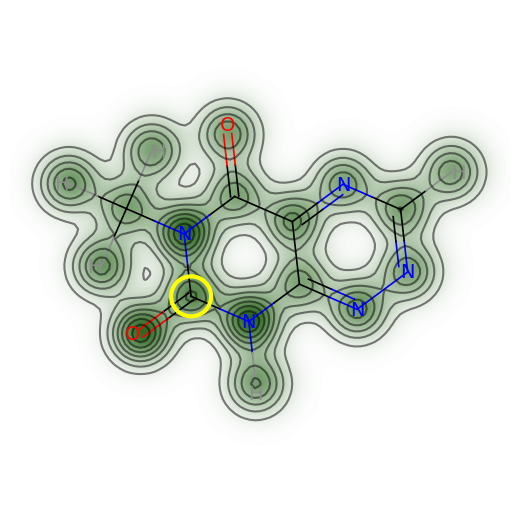

In [38]:
plot = SimilarityMaps.GetSimilarityMapFromWeights(mol=mol, 
                                           weights=attention_data_for_atom_normalized, 
                                           # colorMap="Oranges", 
                                           contourLines=8, 
                                           size=(200, 200),)
# draw circle around atom of interest
atom_x, atom_y = mol._atomPs[atom_idx_to_draw]
plot.add_artist(plt.Circle((2.5*atom_x, 2.5*atom_y), radius=0.1, color="yellow", fill=False, linewidth=3))

In most cases the attention values correspond to general chemical knowledge of how partial charges are determined in tabulated force fields. Strong functional groups, e.g. containing oxygen and/or nitrogen atoms have a high attention. The attention normally quickly decays after a radius of 1 atom, except for conjugated systems. We can visualize fragments with the highest attention in a similar style as above with an arbitrary number of neighbours included. In practice, this value would be chosen dynamically in the tree based on the already included sum of node attentions.

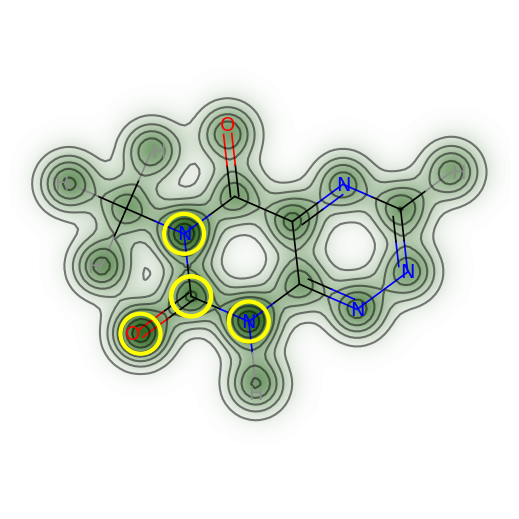

In [39]:
# 4 atoms with highest attention
top_4_atoms = np.argsort(attention_data_for_atom_normalized)[-4:]
for atom_idx in top_4_atoms:
    atom_x, atom_y = mol._atomPs[atom_idx]
    plot.add_artist(plt.Circle((2.5*atom_x, 2.5*atom_y), radius=0.1, color="yellow", fill=False, linewidth=3))
plot

The dynamic inclusion of neighbors is done with a decision tree, built sequentially in order of the highest attention values. The inclusion continues until an optimal threshold is reached. This is described in a seperate notebook. And all that's left to do here is clean up the temporary files.

In [40]:
os.remove("extraction.csv")